In [ ]:

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from google.colab import drive
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.get_device_name(0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'Tesla P100-PCIE-16GB'

In [ ]:

class SpatialTemoralLSTMCell(torch.nn.Module):
    
    def __init__(self, image_shape, in_channel, hidden_channels, kernel_size, stride=1):
        super(SpatialTemoralLSTMCell, self).__init__()
        """
        hidden_channels: Number of hidden features map 
        """
        self.hidden_channels = hidden_channels
        self.padding = kernel_size//2
        self.stride = stride
        
        self.g_bias, self.i_bias, self.f_bias, self.o_bias, self.g_prime_bias, self.i_prime_bias, self.f_prime_bias = torch.nn.Parameter(torch.rand(7))
        
        self.conv_x = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channel, out_channels=self.hidden_channels*7, kernel_size=kernel_size, padding=self.padding, stride=self.stride),
            # Add layer norm to stablize and speed up the training processing
            torch.nn.LayerNorm([hidden_channels*7, image_shape[0], image_shape[1]])
        )
        
        self.conv_h_prev = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=self.hidden_channels, out_channels=self.hidden_channels*4, kernel_size=kernel_size, padding=self.padding, stride=self.stride),
            torch.nn.LayerNorm([hidden_channels*4, image_shape[0], image_shape[1]])
        )
        
        self.conv_m_prev = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=self.hidden_channels, out_channels=self.hidden_channels*3, kernel_size=kernel_size, padding=self.padding, stride=self.stride),
            torch.nn.LayerNorm([hidden_channels*3, image_shape[0], image_shape[1]])
        )
        
        self.conv_c = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=self.hidden_channels, out_channels=self.hidden_channels, kernel_size=kernel_size, padding=self.padding, stride=self.stride),
            torch.nn.LayerNorm([hidden_channels, image_shape[0], image_shape[1]])
        )
        
        self.conv_m = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=self.hidden_channels, out_channels=self.hidden_channels, kernel_size=kernel_size, padding=self.padding, stride=self.stride),
            torch.nn.LayerNorm([hidden_channels, image_shape[0], image_shape[1]])
        )
        
        self.conv_c_m = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=self.hidden_channels*2, out_channels=self.hidden_channels, kernel_size=1, padding=0, stride=1)
        )
        
    def forward(self, x, h_prev, c_prev, m_prev):
        conv_x = self.conv_x(x)
        g_x, i_x, f_x, o_x, g_x_prime, i_x_prime, f_x_prime = torch.split(tensor=conv_x, split_size_or_sections=self.hidden_channels, dim=1)
        conv_h_prev = self.conv_h_prev(h_prev)
        g_h, i_h, f_h, o_h = torch.split(tensor=conv_h_prev, split_size_or_sections=self.hidden_channels, dim=1)
        g = torch.tanh(g_x + g_h + self.g_bias)
        i = torch.sigmoid(i_x + i_h + self.i_bias)
        f = torch.sigmoid(f_x + f_h + self.f_bias)
        c = f * c_prev + i * g
        
        conv_m_prev = self.conv_m_prev(m_prev)
        g_m_prime, i_m_prime, f_m_prime = torch.split(tensor=conv_m_prev, split_size_or_sections=self.hidden_channels, dim=1)
        g_prime = torch.tanh(g_x_prime + g_m_prime + self.g_prime_bias)
        i_prime = torch.sigmoid(i_x_prime + i_m_prime + self.i_prime_bias)
        f_prime = torch.sigmoid(f_x_prime + f_m_prime + self.f_prime_bias)
        m = f_prime * m_prev + i_prime * g_prime
        
        o_c = self.conv_c(c)
        o_m = self.conv_m(m)
        o = torch.sigmoid(o_x + o_h + o_c + o_m + self.o_bias)
        
        c_m_cat = torch.cat((c,m), dim=1)
        h = o * torch.tanh(self.conv_c_m(c_m_cat))
        return h, c, m
        


In [ ]:


class PredRNN(torch.nn.Module):
    
    def __init__(self, nb_layers, image_shape, in_channel, hidden_layer_dim, kernel_size, stride=1):
        super(PredRNN, self).__init__()
        
        self.nb_layers = nb_layers
        self.hidden_layer_dim = hidden_layer_dim
        self.cell_list = []
        # Fixed hidden layer dim for every layer ==> Fix later by changing param hidden_layer_dim from int to list of int
        for i in range(nb_layers):
            if i == 0:
                new_cell = SpatialTemoralLSTMCell(image_shape=image_shape, in_channel=in_channel, 
                                                  hidden_channels=hidden_layer_dim, kernel_size=kernel_size, stride=stride)
            else:
                new_cell = SpatialTemoralLSTMCell(image_shape=image_shape, in_channel=hidden_layer_dim, 
                                                  hidden_channels=hidden_layer_dim, kernel_size=kernel_size, stride=stride)
            self.cell_list.append(new_cell)
            
        self.cell_list = torch.nn.ModuleList(self.cell_list)
        self.output_conv = torch.nn.Conv2d(in_channels=hidden_layer_dim, out_channels=in_channel, kernel_size=1, stride=1)
            
    
    def forward(self, batch_of_sequences, total_length, device="cuda"):
        batch, length, nb_channels, height, width = batch_of_sequences.shape
        
        h_list = []
        c_list = []
        for i in range(self.nb_layers):
            h_list.append(torch.zeros(batch, self.hidden_layer_dim, height, width, device=device))
            c_list.append(torch.zeros(batch, self.hidden_layer_dim, height, width, device=device))

        memory = torch.zeros(batch, self.hidden_layer_dim, height, width, device=device)

        prediction = []
        # Recurrent flow (For each timestep, perform vertical flow first)
        for t in range(total_length):
            if (t > length - 1 ):
                input_frame = prediction[-1]
            else:
                input_frame = batch_of_sequences[:, t]
            h_list[0], c_list[0], memory = self.cell_list[0](input_frame, h_list[0], c_list[0], memory)
            for layer in range(1, self.nb_layers):
                h_list[layer], c_list[layer], memory = self.cell_list[layer](h_list[layer-1], h_list[layer], c_list[layer], memory)
            timestep_prediction = self.output_conv(h_list[-1])
            prediction.append(timestep_prediction)

        prediction = torch.stack(prediction).permute(1,0,2,3,4)
        return prediction
            



In [ ]:
# pred_rnn = PredRNN(nb_layers=4, image_shape=(64,64,1), in_channel=1, hidden_layer_dim=128, kernel_size=5, stride=1)
# pred_rnn = pred_rnn.to(device=device)
# optim = torch.optim.Adam(params=pred_rnn.parameters(), lr=0.001)
# l1_loss = torch.nn.L1Loss()
# l2_loss = torch.nn.MSELoss()

# for sequence, target in tqdm(training_set):
#     sequence = sequence.to(device=device)
#     target = target.to(device=device)
#     pred = pred_rnn(sequence)
#     loss = l2_loss(pred, target) + l1_loss(pred, target)
#     optim.zero_grad()
#     loss.backward()
#     optim.step()
#     epoch_train_loss.append(loss.item())

In [ ]:

def show_image(sequence, ground_truth, prediction):
    grid = torchvision.utils.make_grid(sequence, nrow=10)
    grid = grid.permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)
    plt.title("Input images")
    plt.show()

    grid = torchvision.utils.make_grid(ground_truth, nrow=10)
    grid = grid.permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)
    plt.title("Ground truth")
    plt.show()

    grid = torchvision.utils.make_grid(prediction, nrow=10)
    grid = grid.permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)
    plt.title("Prediction")
    plt.show()
    
def save_model(epoch, model, optim, train_loss, val_loss, save_path):
    check_point = {
        "epoch": epoch, 
        "model_state_dict": model.state_dict(),
        "optim_state_dict": optim.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss
    }
    torch.save(check_point, save_path)
    print("Save model succesfully")



In [ ]:

# Load dataset
training_set =  np.load("./drive/MyDrive/pred_cnn/mnist_train_seq.npy")
training_set = training_set.reshape(80000, 20, 1, 64, 64)
x_train, y_train = torch.tensor(training_set[:10000, :10, ...]).float(), torch.tensor(training_set[:10000, 1:21, ...]).float()
del training_set

testing_set = np.load("./drive/MyDrive/pred_cnn/mnist_test_seq.npy")
testing_set = testing_set.reshape(10000, 20, 1, 64, 64)
x_val, y_val = torch.tensor(testing_set[:5000, :10, ...]).float(), torch.tensor(testing_set[:5000, 1:21, ...]).float()
x_test, y_test = torch.tensor(testing_set[5000:, :10, ...]).float(), torch.tensor(testing_set[5000:, 1:21, ...]).float()
del testing_set

training_set = DataLoader(TensorDataset(x_train, y_train), batch_size=1, shuffle=True)
validation_set = DataLoader(TensorDataset(x_val, y_val), batch_size=1, shuffle=False)
testing_set = DataLoader(TensorDataset(x_test, y_test), batch_size=1, shuffle=False)

# Init model, parameters
pred_rnn = PredRNN(nb_layers=4, image_shape=(64,64,1), in_channel=1, hidden_layer_dim=128, kernel_size=5, stride=1)
pred_rnn = pred_rnn.to(device=device)
optim = torch.optim.Adam(params=pred_rnn.parameters(), lr=0.001)
l1_loss = torch.nn.L1Loss()
l2_loss = torch.nn.MSELoss()
train_loss = []
val_loss = []
current_epoch = -1
epochs = 20


In [ ]:

check_point = torch.load("./drive/MyDrive/pred_cnn/combined_loss_epoch0.pt")
print(list(check_point.keys()))

current_epoch = check_point["epoch"] + 1
pred_rnn.load_state_dict(check_point["model_state_dict"])
optim.load_state_dict(check_point["optim_state_dict"])
train_loss = check_point["train_loss"]
val_loss = check_point["val_loss"]
print(f"Load check point at epoch {current_epoch} successfully")


['epoch', 'model_state_dict', 'optim_state_dict', 'train_loss', 'val_loss']
Load check point at epoch 1 successfully


Epoch 2


Current training loss: 0.07963551580905914


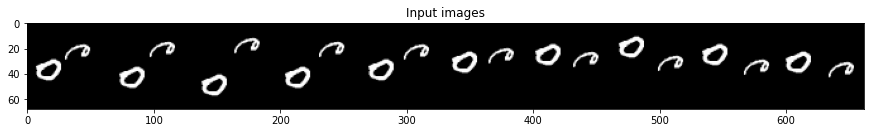

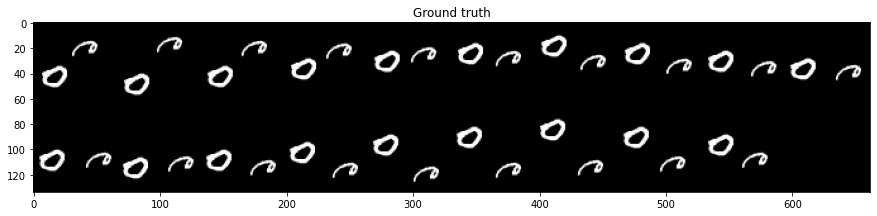

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


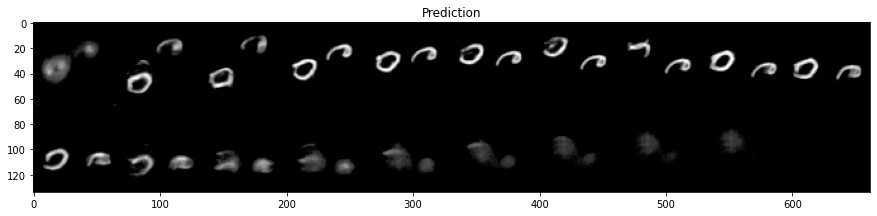

Current training loss: 0.05800566783252947


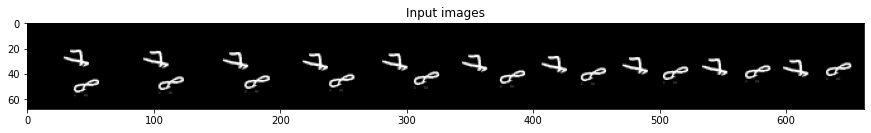

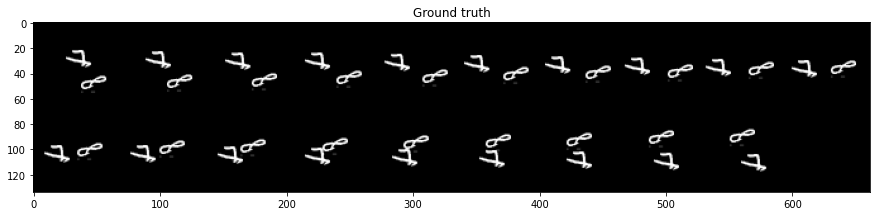

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


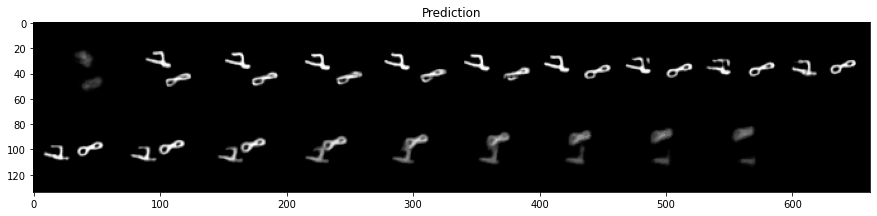

Current training loss: 0.05746080742760019


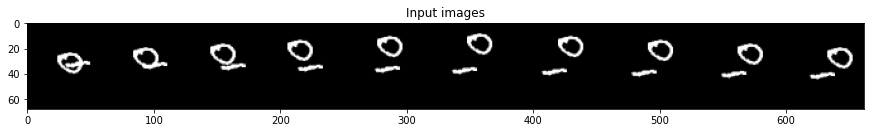

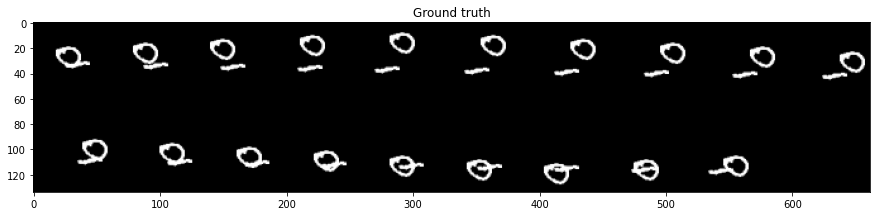

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


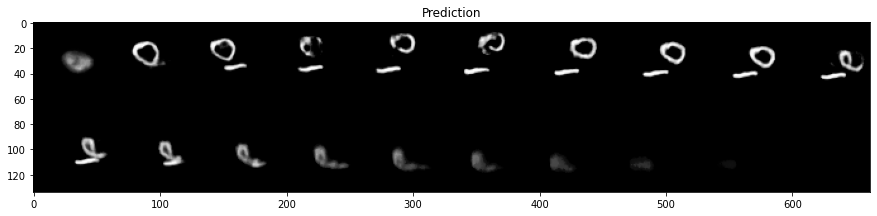

Current training loss: 0.05731632947787732


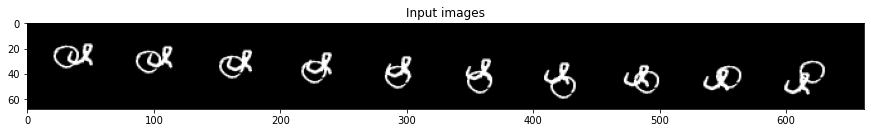

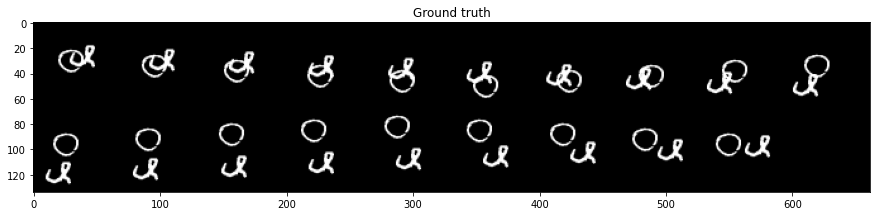

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


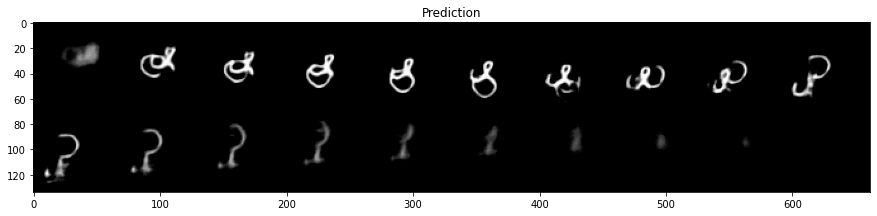

Current training loss: 0.057194110034019696


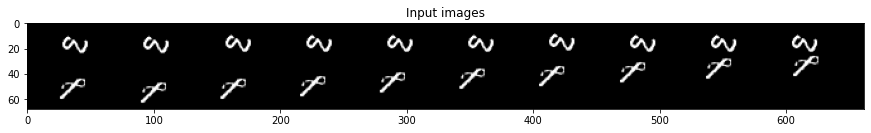

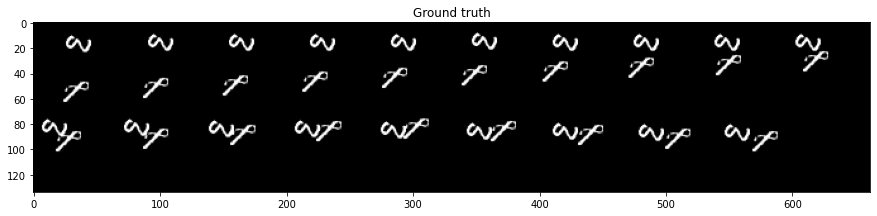

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


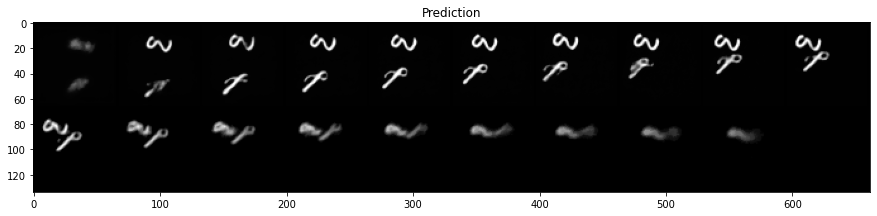

Current training loss: 0.057115684794794556


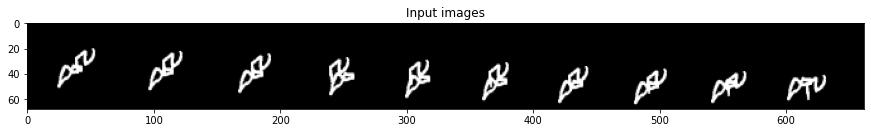

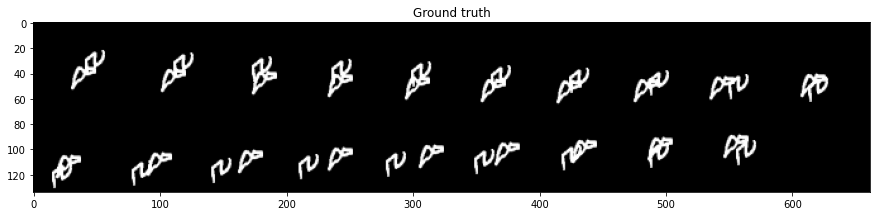

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


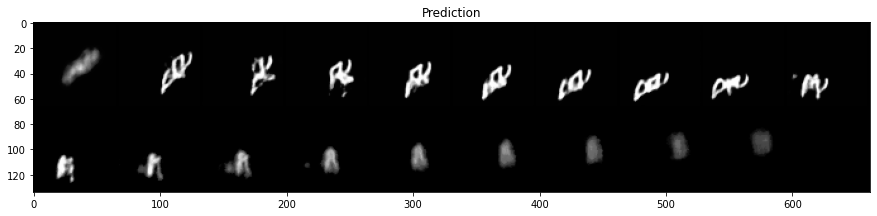

Current training loss: 0.05703651358493564


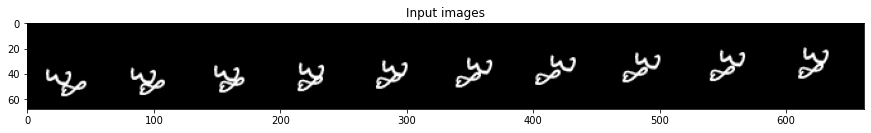

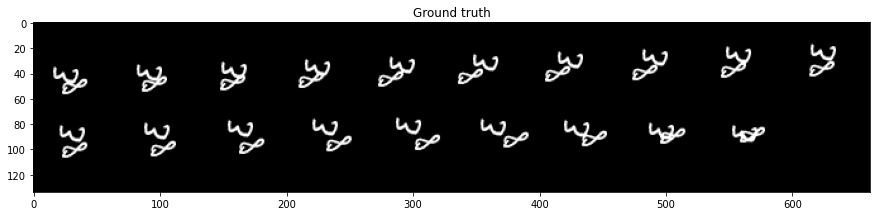

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


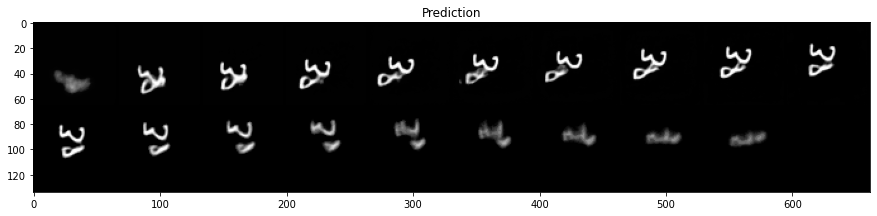

Current training loss: 0.05692852442082304


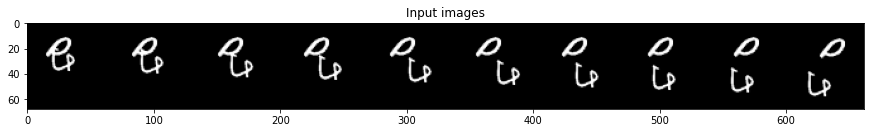

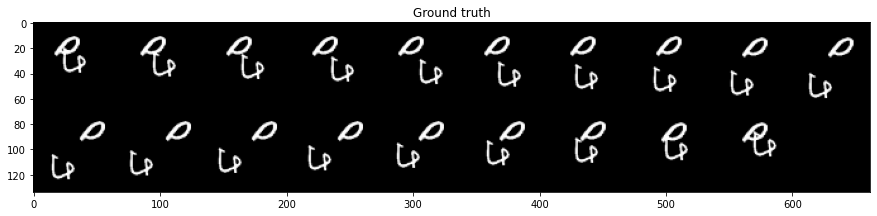

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


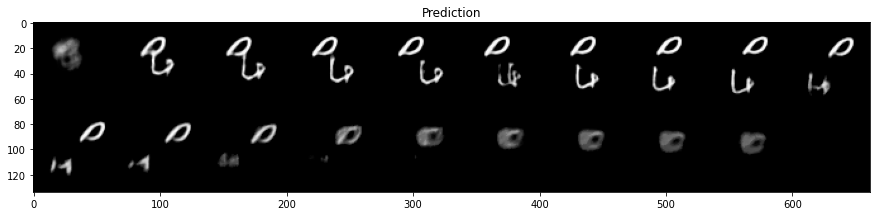

Current training loss: 0.05690945337240889


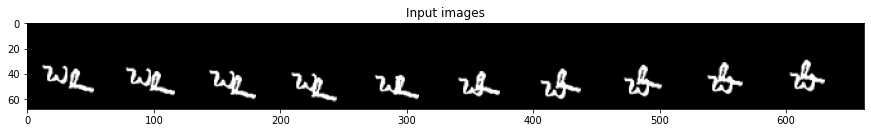

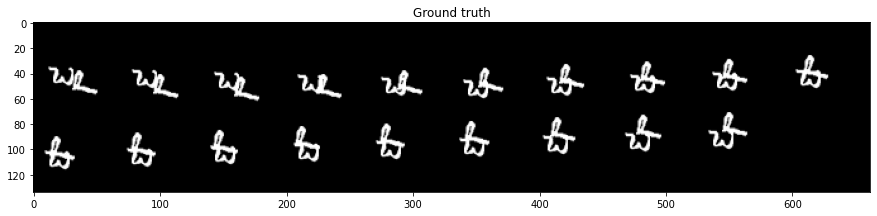

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


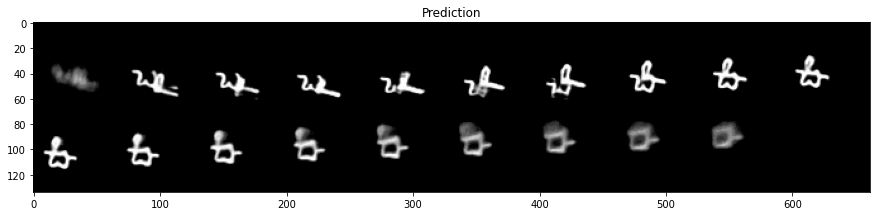

Current training loss: 0.05687180050694063


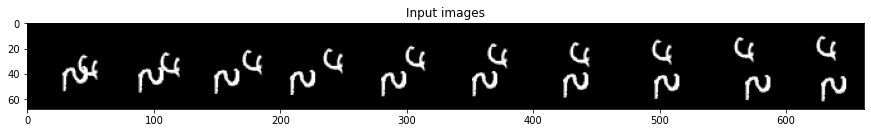

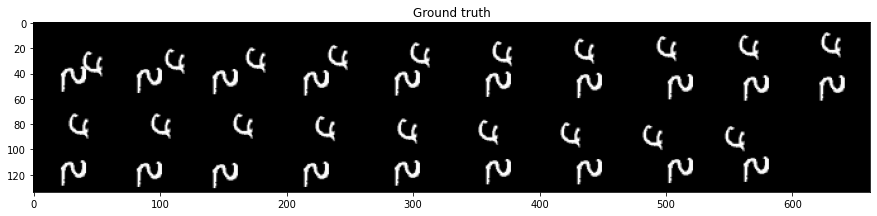

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


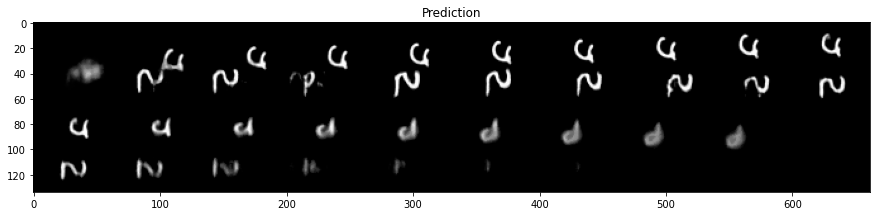

Current training loss: 0.05683800707210114


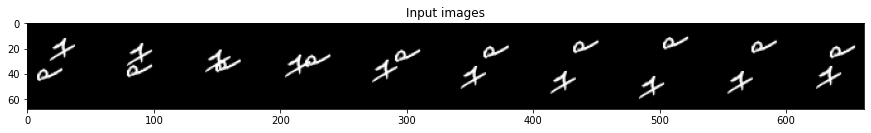

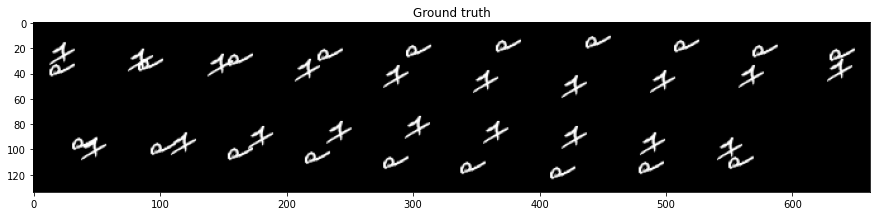

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


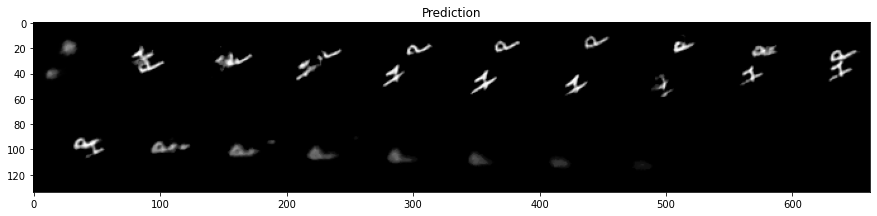

Current training loss: 0.05680569119167705


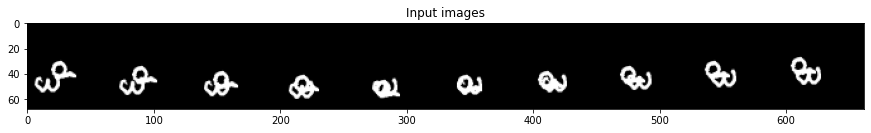

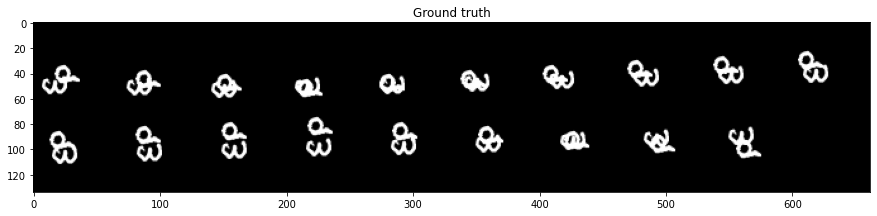

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


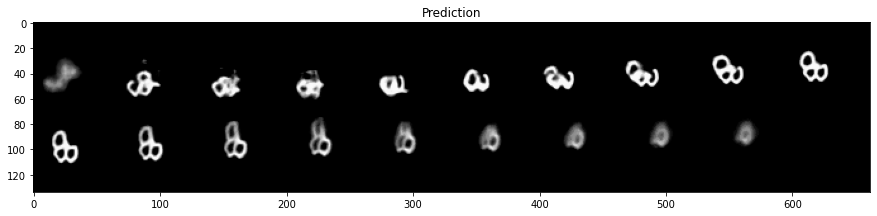

Current training loss: 0.056818336458531266


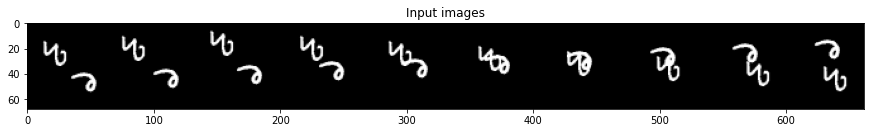

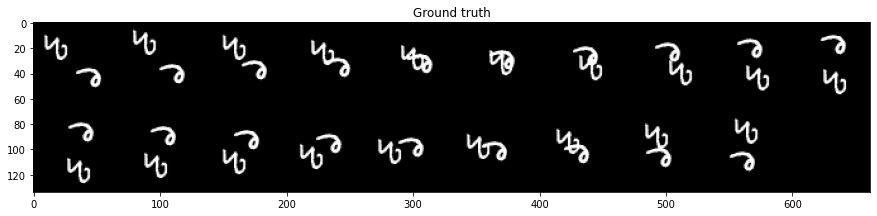

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


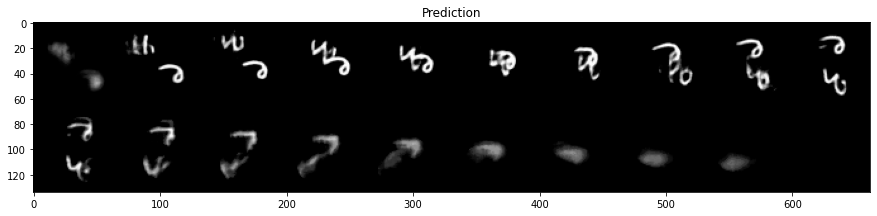

Current training loss: 0.05677225288199087


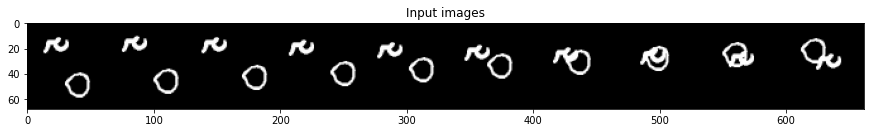

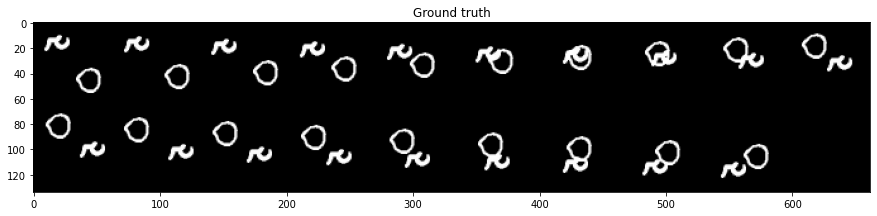

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


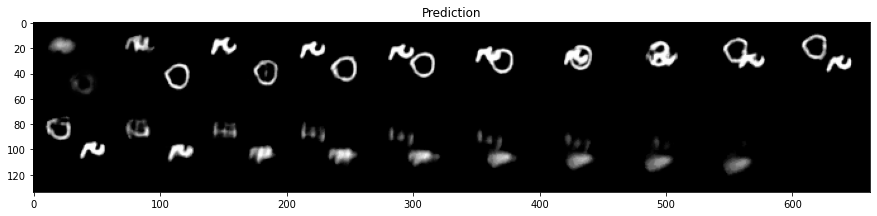

Current training loss: 0.05668125018438064


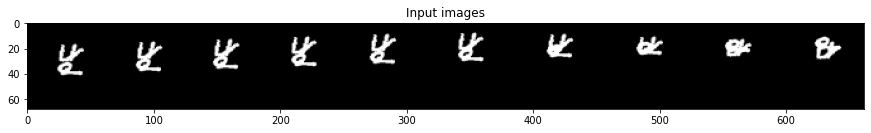

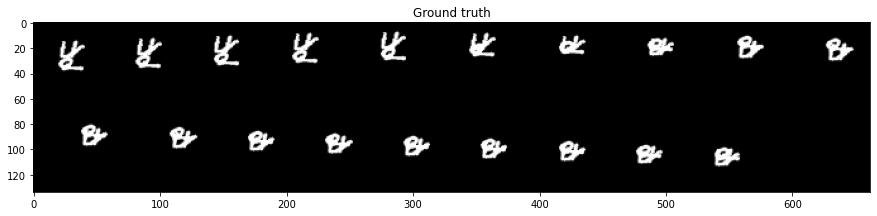

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


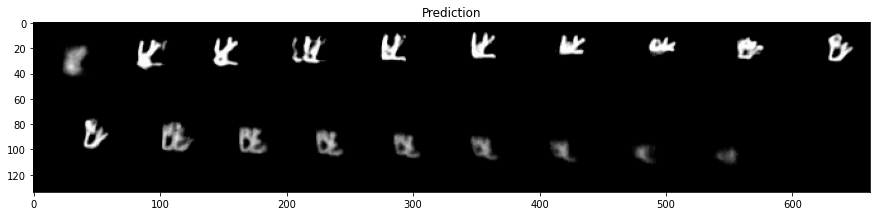

Current training loss: 0.05664587340039176


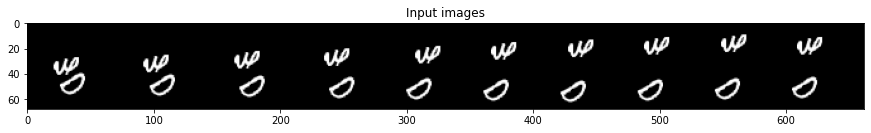

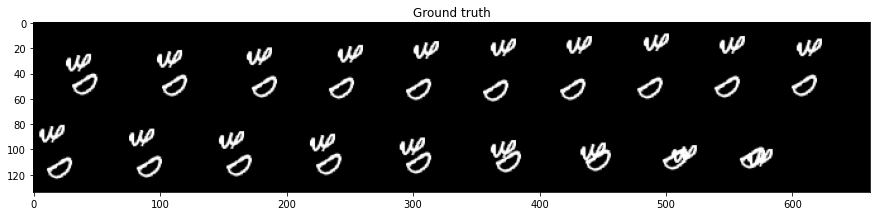

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


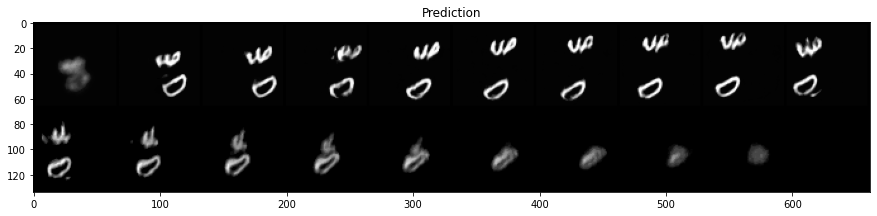

Current training loss: 0.05666471586453625


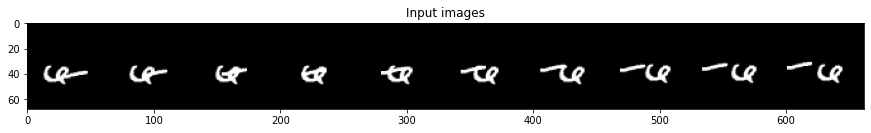

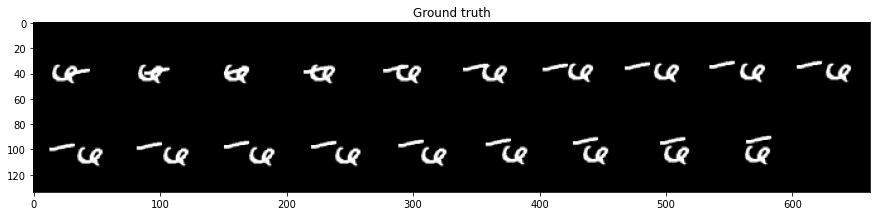

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


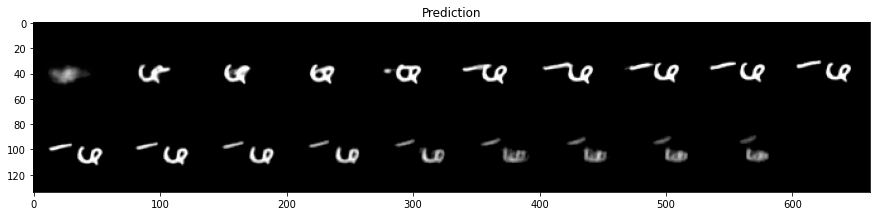

Current training loss: 0.056629155562556696


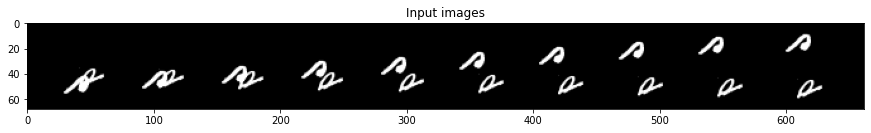

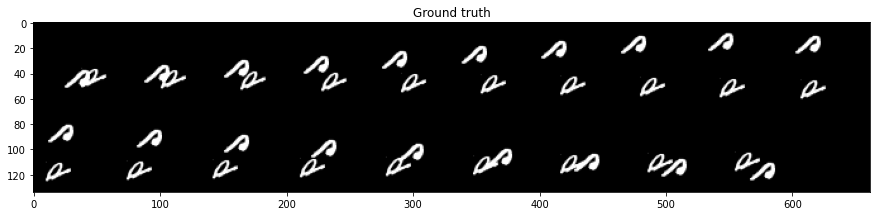

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


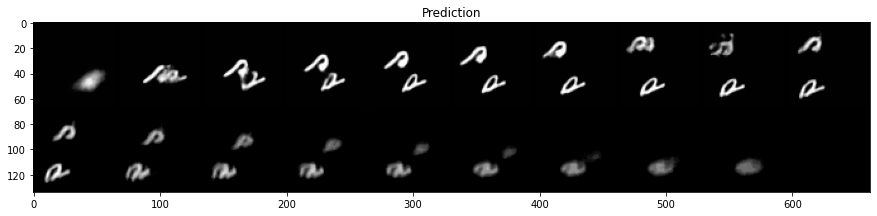

Current training loss: 0.0565942378077106


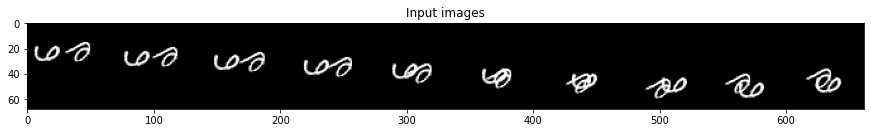

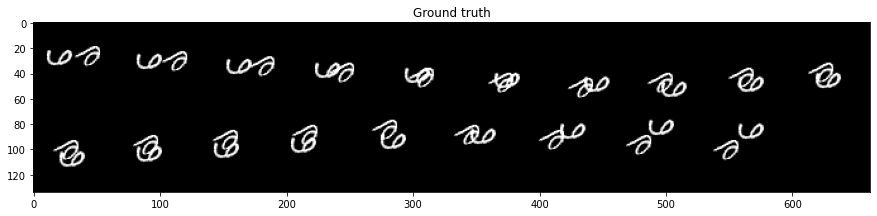

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


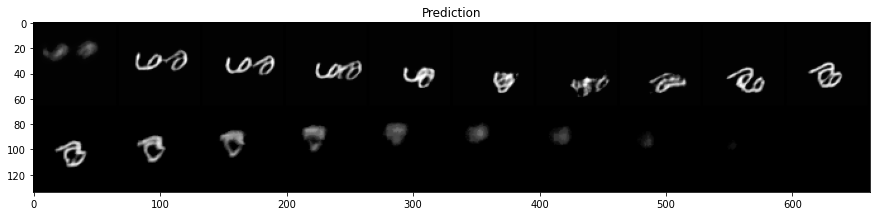

Current training loss: 0.05653508437144394


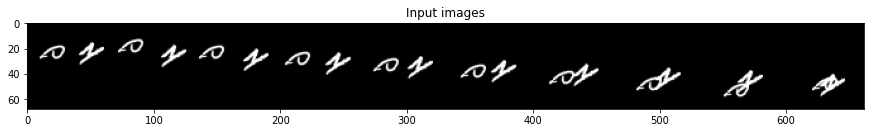

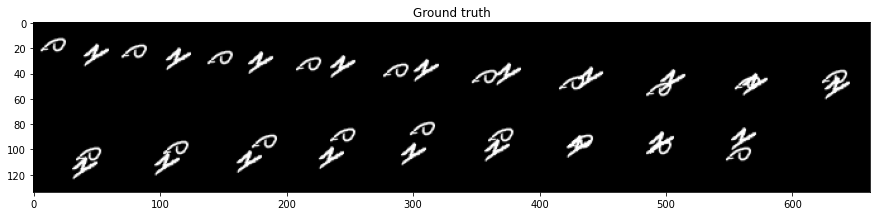

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


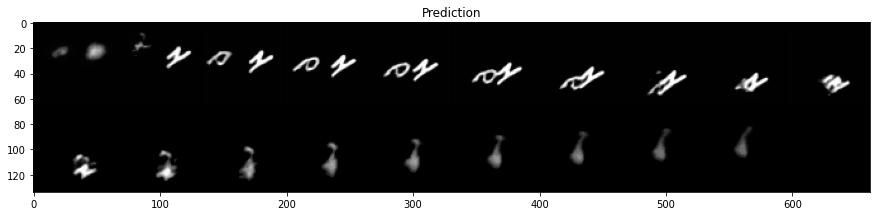


Save model succesfully


In [ ]:

for epoch in range(current_epoch+1, epochs):
    print(f"Epoch {epoch}")
    # Training
    epoch_train_loss = []
    pred_rnn.train()

    sample_index = 0
    for sequence, target in tqdm(training_set):
        sequence = sequence.to(device=device) / 255.0
        target = target.to(device=device) / 255.0
        pred = pred_rnn(batch_of_sequences=sequence, total_length=target.shape[1])
        loss = l2_loss(pred, target) + l1_loss(pred, target)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
        # Show result every 500 iterations of training
        if (sample_index % 500 == 0):
            print(f"Current training loss: {np.mean(epoch_train_loss)}")
            show_image(sequence[0,:], target[0,0:], pred[0,0:])
        sample_index += 1

    epoch_train_loss = np.mean(epoch_train_loss)
    train_loss.append(epoch_train_loss)
    save_model(epoch, pred_rnn, optim, train_loss, val_loss, f"./drive/MyDrive/pred_cnn/combined_loss_epoch{epoch}.pt")


    # Validation
    epoch_val_loss = []
    pred_rnn.eval()
    with torch.no_grad():
        for sequence, target in tqdm(validation_set):
            sequence = sequence.to(device=device) / 255.0
            target = target.to(device=device) / 255.0
            pred = pred_rnn(batch_of_sequences=sequence, total_length=target.shape[1])
            loss = l2_loss(pred, target) + l1_loss(pred, target)
            epoch_val_loss.append(loss.item())
    epoch_val_loss = np.mean(epoch_val_loss)
    val_loss.append(epoch_val_loss)
    
    save_model(epoch, pred_rnn, optim, train_loss, val_loss, f"./drive/MyDrive/pred_cnn/combined_loss_epoch{epoch}.pt")
    
    print(f"Finish epoch {epoch}. Train_loss = {epoch_train_loss}, Val_loss = {epoch_val_loss}")
    show_image(sequence[0,:], target[0,10:], pred[0,10:])



In [ ]:
# Validation
epoch_val_loss = []
pred_rnn.eval()
sample_index = 0
with torch.no_grad():
    for sequence, target in tqdm(validation_set):
        sequence = sequence.to(device=device) / 255.0
        target = target.to(device=device) / 255.0
        pred = pred_rnn(batch_of_sequences=sequence, total_length=target.shape[1])
        loss = l2_loss(pred, target) + l1_loss(pred, target)
        epoch_val_loss.append(loss.item())
        if (sample_index % 20 == 0):
            print(f"Current training loss: {np.mean(epoch_train_loss)}")
            show_image(sequence[0,:], target[0,0:], pred[0,0:])
        sample_index += 1

epoch_val_loss = np.mean(epoch_val_loss)
val_loss.append(epoch_val_loss)


In [ ]:
    
save_model(epoch, pred_rnn, optim, train_loss, val_loss, f"./drive/MyDrive/pred_cnn/combined_loss_epoch{epoch}.pt")
